In [312]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

from scipy.stats import ttest_ind
from scipy.stats import f_oneway
%matplotlib inline

In [313]:
con = sqlite3.connect('Northwind_small.sqlite')
c = con.cursor()
print("Opened database successfully")

Opened database successfully


In [314]:
for row in c.execute("SELECT name FROM sqlite_master WHERE type='table';"):
    print(row)

('Employee',)
('Category',)
('Customer',)
('Shipper',)
('Supplier',)
('Order',)
('Product',)
('OrderDetail',)
('CustomerCustomerDemo',)
('CustomerDemographic',)
('Region',)
('Territory',)
('EmployeeTerritory',)
('SCHOOL',)


In [315]:
employee_table = pd.read_sql_query("SELECT * FROM Employee", con)
category_table = pd.read_sql_query("SELECT * FROM Category", con)
customer_table = pd.read_sql_query("SELECT * FROM Customer", con)
shipper_table = pd.read_sql_query("SELECT * FROM Shipper", con)
supplier_table = pd.read_sql_query("SELECT * FROM Supplier", con)
order_table = pd.read_sql_query("SELECT * FROM [Order]", con)
product_table = pd.read_sql_query("SELECT * FROM Product", con)
orderdetail_table = pd.read_sql_query("SELECT * FROM OrderDetail", con)
customercustomerdemo_table = pd.read_sql_query("SELECT * FROM CustomerCustomerDemo", con)
customerdemographic_table = pd.read_sql_query("SELECT * FROM CustomerDemographic", con)
region_table = pd.read_sql_query("SELECT * FROM Region", con)
territory_table = pd.read_sql_query("SELECT * FROM Territory", con)
employeeterritory_table = pd.read_sql_query("SELECT * FROM EmployeeTerritory", con)


In [316]:
orderdetail_table.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


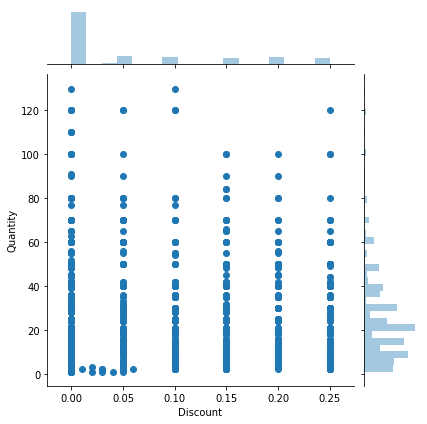

In [317]:
sns.jointplot(x='Discount',y = 'Quantity',data = orderdetail_table,kind = 'scatter')

In [318]:
#breakdown the table into data sets by discount in groups of 5%. Also divided data into all discounted and nondiscounted
discount_0_05 = pd.read_sql_query("SELECT * FROM orderdetail WHERE Discount BETWEEN 0.001 and .05", con)
print("Total number of orders discounted from 1% to 5%= {}".format(len(discount_0_05)))
discount_05_1 = pd.read_sql_query("SELECT * FROM orderdetail WHERE Discount BETWEEN .051 and .1", con)
print("Total number of orders discounted from 5% to 10%= {}".format(len(discount_05_1)))
discount_1_15 = pd.read_sql_query("SELECT * FROM orderdetail WHERE Discount BETWEEN .11 and .15", con)
print("Total number of orders discounted from 10% to 15%= {}".format(len(discount_1_15)))
discount_15_2 = pd.read_sql_query("SELECT * FROM orderdetail WHERE Discount BETWEEN .151 and .20", con)
print("Total number of orders discounted from 15% to 20%= {}".format(len(discount_15_2)))
discount_2_25 = pd.read_sql_query("SELECT * FROM orderdetail WHERE Discount BETWEEN .21 and .25", con)
print("Total number of orders discounted from 20% to 25%= {}".format(len(discount_2_25)))

no_discount = pd.read_sql_query("SELECT * FROM orderdetail WHERE Discount = 0", con)
print("Total number of orders with no discount= {}".format(len(no_discount)))
discounts = pd.read_sql_query("SELECT * FROM orderdetail WHERE Discount BETWEEN .001 and .25", con)
print("Total number of orders discounted = {}".format(len(discounts)))


Total number of orders discounted from 1% to 5%= 192
Total number of orders discounted from 5% to 10%= 174
Total number of orders discounted from 10% to 15%= 157
Total number of orders discounted from 15% to 20%= 161
Total number of orders discounted from 20% to 25%= 154
Total number of orders with no discount= 1317
Total number of orders discounted = 838


## Question 1
### H0: mean quantity of non discounted orders equals mean quantity of discounted orders
### HA: mean quantity of non discount orders does not equal mean quantity of discounted orders

In [319]:
#using the levene test to test if there is a significance 
#p is less then .05 so we reject the null hypothesis and cant use ANOVA
print(stats.levene(no_discount['Quantity'], discount_0_05['Quantity']))
print(stats.levene(no_discount['Quantity'], discount_05_1['Quantity']))
print(stats.levene(no_discount['Quantity'], discount_1_15['Quantity']))
print(stats.levene(no_discount['Quantity'], discount_15_2['Quantity']))
print(stats.levene(no_discount['Quantity'], discount_2_25['Quantity']))

print(stats.levene(no_discount['Quantity'], discounts['Quantity']))

LeveneResult(statistic=7.598798646837281, pvalue=0.005911146478108135)
LeveneResult(statistic=1.9602714878584622, pvalue=0.1616926093213866)
LeveneResult(statistic=6.621394134971047, pvalue=0.010173258822969699)
LeveneResult(statistic=4.2893069280815554, pvalue=0.038526244167615964)
LeveneResult(statistic=4.191961687777951, pvalue=0.04079361481086336)
LeveneResult(statistic=14.832671704073421, pvalue=0.00012091378376079568)


Above we tested the variance and got all but one pvalue to be less than .05, which means the variance is not equal throughout. Since the variance is not equal we will use a Welch Test to find statistical significance. 

In [320]:
# Levene test has a p value less than .05, meaning the variance is not equal. We must do the welch test
def welch_ttest(x, y): 
    ## Welch-Satterthwaite Degrees of Freedom ##
    dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
   
    t, p = stats.ttest_ind(x, y, equal_var = False)
    
    print("\n",
          f"Welch's t-test= {t:.4f}", "\n",
          f"p-value = {p:.16f}", "\n",
          f"Welch-Satterthwaite Degrees of Freedom= {dof:.4f}")

welch_ttest(no_discount['Quantity'], discounts['Quantity'])




 Welch's t-test= -6.2391 
 p-value = 0.0000000005656414 
 Welch-Satterthwaite Degrees of Freedom= 1561.7678


P value is less than .05, which means we reject the null hypothesis. This means that the mean quantity of non discounted orders does not equal the mean quantity of disocunted orders. This makes sense because we would assume that an item having a discount would effect the quantity of items a customer purchases.

# Question 2
### H0: the mean quantity of items ordered for the various level of discounts are equal 
### HA: the mean quantity of items ordered for the various level of discounts do not equal (the level of discount affects the number of items ordered)

In [321]:
#mean quantity of orders for the different levels of discount 
print(np.mean(no_discount['Quantity']))
print(np.mean(discount_0_05['Quantity']))
print(np.mean(discount_05_1['Quantity']))
print(np.mean(discount_1_15['Quantity']))
print(np.mean(discount_15_2['Quantity']))
print(np.mean(discount_2_25['Quantity']))

21.715261958997722
27.052083333333332
25.103448275862068
28.38216560509554
27.024844720496894
28.24025974025974


We will run an ANOVA test to compare all the discounted values at once to see if one discount value is more significant than the other. To run the ANOVA test, we are using a random sample of 100 from each discount group. We did this because the non discounted group is so much larger we did not want it to scew the results.

In [322]:
#ANOVA test to compare all discount values at once to see if one is more significant than the other 
#(i thnk the values were scewed because the no discount group has significant more values than the 
#other discount groups)

#created a for loop to pull random values all of the same group size

pvals=[]

for test in range(30):
    d0 = np.random.choice(no_discount['Quantity'], size=100)
    d05 = np.random.choice(discount_0_05['Quantity'], size=100)
    d1 = np.random.choice(discount_05_1['Quantity'],size=100)
    d15 = np.random.choice(discount_1_15['Quantity'],size=100)
    d2 = np.random.choice(discount_15_2['Quantity'],size=100)
    d25 = np.random.choice(discount_2_25['Quantity'],size=100)
    
    s, p = stats.f_oneway(d0, d05, d1, d15, d2, d25)
    pvals.append(p)

np.mean(pvals)

0.12320351805342018

The P value is greater than .05 so we accept the null hypothesis. This means that the mean quantity of items ordered is the same throughout the different levels of discount. Meaning higher discounted items are not necessarily ordered more than items with a small discount. 

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


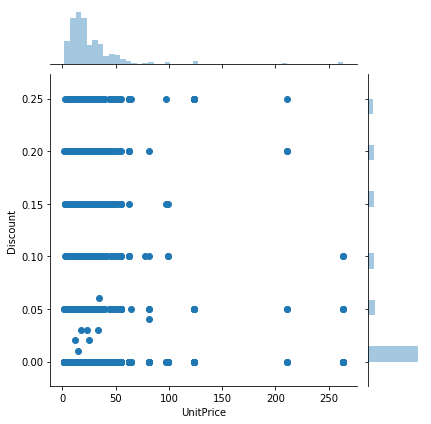

In [323]:
sns.jointplot(x='UnitPrice',y = 'Discount',data = orderdetail_table,kind = 'scatter')

## Question 3

### H0: the mean discount of items ordered for the various level of unit prices are equal 
### HA: the mean discount of items ordered for the various level of unit prices do not equal (the unit price affects the discount of items ordered)

In [324]:
price_0_50 = pd.read_sql_query("SELECT * FROM orderdetail WHERE UnitPrice BETWEEN 0 and 50", con)
print("Total number of items order where Unit Price ranges from 0 to 50= {}".format(len(price_0_50)))
price_50_100 = pd.read_sql_query("SELECT * FROM orderdetail WHERE UnitPrice BETWEEN 50.01 and 100", con)
print("Total number of items order where Unit Price ranges from 50 to 100= {}".format(len(price_50_100)))
price_100_150 = pd.read_sql_query("SELECT * FROM orderdetail WHERE UnitPrice BETWEEN 100.01 and 150", con)
print("Total number of items order where Unit Price ranges from 100 to 150= {}".format(len(price_100_150)))
price_150_200 = pd.read_sql_query("SELECT * FROM orderdetail WHERE UnitPrice BETWEEN 150.01 and 200", con)
print("Total number of items order where Unit Price ranges from 150 to 200= {}".format(len(price_150_200)))
price_200_250 = pd.read_sql_query("SELECT * FROM orderdetail WHERE UnitPrice BETWEEN 200.01 and 250", con)
print("Total number of items order where Unit Price ranges from 200 to 250= {}".format(len(price_200_250)))
price_250_300 = pd.read_sql_query("SELECT * FROM orderdetail WHERE UnitPrice BETWEEN 250.01 and 300", con)
print("Total number of items order where Unit Price ranges from 250 to 300= {}".format(len(price_250_300)))

Total number of items order where Unit Price ranges from 0 to 50= 1992
Total number of items order where Unit Price ranges from 50 to 100= 117
Total number of items order where Unit Price ranges from 100 to 150= 22
Total number of items order where Unit Price ranges from 150 to 200= 0
Total number of items order where Unit Price ranges from 200 to 250= 8
Total number of items order where Unit Price ranges from 250 to 300= 16


In [325]:
#check variance
print(stats.levene(price_0_50['Discount'], price_50_100['Discount'], price_100_150['Discount'], 
                    price_200_250['Discount'], price_250_300['Discount']))

LeveneResult(statistic=1.2572042994778685, pvalue=0.2847133860905552)


Used the Levene Test to check variance. The p value is greater than .05 so we can use the ANOVA test to check statistical significance.

In [326]:
fstat, pval = stats.f_oneway(price_0_50['Discount'], price_50_100['Discount'], price_100_150['Discount'], 
                                price_200_250['Discount'], price_250_300['Discount'])

pval

0.2058050087140513

The p value is greater than .05 so we accept the null hypothesis, this shows that the level of discount does not change depending on unit price of an item. Maybe if the discount was greater for more expensive items there would be an increase in orders. 

## Question 4
### H0: the mean discount for each category of items is equal
### HA: the mean discount for each category of items is not equal

To run this test we firts need to join the order details and product tables to compare category ID and discount.

In [327]:
product_table.head(1)

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0


In [328]:
orderdetail_table.head(1)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0


In [329]:
join_query = """SELECT OrderDetail.ProductId, CategoryId, Quantity, Discount
FROM orderdetail
JOIN product 
ON orderdetail.ProductId = Product.Id"""

In [330]:
join_query

'SELECT OrderDetail.ProductId, CategoryId, Quantity, Discount\nFROM orderdetail\nJOIN product \nON orderdetail.ProductId = Product.Id'

In [331]:
odpdf = pd.read_sql_query(join_query, con)
odpdf.head()

,ProductId,CategoryId,Quantity,Discount
0,11,4,12,0.0
1,42,5,10,0.0
2,72,4,5,0.0
3,14,7,9,0.0
4,51,7,40,0.0


In [332]:
cat_1 = odpdf.loc[odpdf.CategoryId == 1]
cat_2 = odpdf.loc[odpdf.CategoryId == 2]
cat_3 = odpdf.loc[odpdf.CategoryId == 3]
cat_4 = odpdf.loc[odpdf.CategoryId == 4]
cat_5 = odpdf.loc[odpdf.CategoryId == 5]
cat_6 = odpdf.loc[odpdf.CategoryId == 6]
cat_7 = odpdf.loc[odpdf.CategoryId == 7]
cat_8 = odpdf.loc[odpdf.CategoryId == 8]

In [333]:
#levene test for variance
print(stats.levene(cat_1['Discount'], odpdf['Discount']))
print(stats.levene(cat_2['Discount'], odpdf['Discount']))
print(stats.levene(cat_3['Discount'], odpdf['Discount']))
print(stats.levene(cat_4['Discount'], odpdf['Discount']))
print(stats.levene(cat_5['Discount'], odpdf['Discount']))
print(stats.levene(cat_6['Discount'], odpdf['Discount']))
print(stats.levene(cat_7['Discount'], odpdf['Discount']))
print(stats.levene(cat_8['Discount'], odpdf['Discount']))

LeveneResult(statistic=1.5660052505513309, pvalue=0.21090257118992378)
LeveneResult(statistic=0.3549647724802563, pvalue=0.5513729733391813)
LeveneResult(statistic=0.025213163313157674, pvalue=0.8738499511136031)
LeveneResult(statistic=0.3364112030845873, pvalue=0.5619599787663906)
LeveneResult(statistic=3.074559184428751, pvalue=0.07965656988510599)
LeveneResult(statistic=1.5629717036461663, pvalue=0.21135639631791997)
LeveneResult(statistic=2.131745439316921, pvalue=0.14441361428607608)
LeveneResult(statistic=0.6770651777384927, pvalue=0.4106781698678509)


The p value is greater than .05 so we can assume equal variance. We will proceed by using the ANOVA test to test stitical significance. 

In [334]:
fstat, pval = stats.f_oneway(cat_1['Discount'], cat_2['Discount'], cat_3['Discount'], 
                                cat_4['Discount'], cat_5['Discount'], cat_6['Discount'],
                            cat_7['Discount'], cat_8['Discount'])

pval



0.14932558623997566

The pvalue is greater than .05 so we can assume the mean discount for each category is similar, meaning the category of items does not influence discounts. We can use this information to see if changing the discounts for certain categories can increase quantity in orders. 

## Question 5
### H0: the mean quantity ordered for each category of items is equal
### HA: the mean quantity ordered for each category of items is not equal¶

In [335]:
#test variance
print(stats.levene(cat_1['Quantity'], odpdf['Quantity']))
print(stats.levene(cat_2['Quantity'], odpdf['Quantity']))
print(stats.levene(cat_3['Quantity'], odpdf['Quantity']))
print(stats.levene(cat_4['Quantity'], odpdf['Quantity']))
print(stats.levene(cat_5['Quantity'], odpdf['Quantity']))
print(stats.levene(cat_6['Quantity'], odpdf['Quantity']))
print(stats.levene(cat_7['Quantity'], odpdf['Quantity']))
print(stats.levene(cat_8['Quantity'], odpdf['Quantity']))

LeveneResult(statistic=0.009848071775278997, pvalue=0.9209575185817495)
LeveneResult(statistic=0.04241228423250917, pvalue=0.836853577549603)
LeveneResult(statistic=0.15747281627033324, pvalue=0.6915280203518689)
LeveneResult(statistic=0.4978733557188787, pvalue=0.480501288733321)
LeveneResult(statistic=0.5788360158489891, pvalue=0.44684529034520126)
LeveneResult(statistic=1.3071043218749905, pvalue=0.25303725817201894)
LeveneResult(statistic=0.38228878918434794, pvalue=0.536442368692101)
LeveneResult(statistic=0.08724598699158045, pvalue=0.7677326472768746)


The p value is greater than .05 so we can assume equal variance. We will proceed by using the ANOVA test to test stitical significance. 